#### Task4 建模调参

## 任务目标：

1. 学习在金融分控领域常用的机器学习模型 
2. 学习机器学习模型的建模过程与调参流程 

1. 逻辑回归模型:
    1. 理解逻辑回归模型; 
    2. 逻辑回归模型的应用; 
    3. 逻辑回归的优缺点;
2. 树模型:
    1. 理解树模型;
    2. 树模型的应用;
    3. 树模型的优缺点; 
3. 集成模型


### 导入需要的库

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from catboost import CatBoostRegressor
import warnings
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss 
warnings.filterwarnings('ignore')

### 读取文件

In [4]:
data_train = pd.read_csv('../train.csv')
data_test_a = pd.read_csv('../testA.csv')

### 特征预处理
数据EDA部分我们已经对数据的大概和某些特征分布有了了解，数据预处理部分一般我们要处理一些EDA阶 段分析出来的问题

首先我们查找出数据中的对象特征和数值特征

In [5]:
numerical_fea = list(data_train.select_dtypes(exclude=['object']).columns) 
category_fea = list(filter(lambda x: x not in numerical_fea,list(data_train.columns))) 
label = 'isDefault'
numerical_fea.remove(label)

在比赛中数据预处理是必不可少的一部分，对于缺失值的填充往往会影响比赛的结果，在比赛中不妨尝试多种填 充然后比较结果选择结果最优的一种; 比赛数据相比真实场景的数据相对要“干净”一些，但是还是会有一定的“脏”数据存在，清洗一些异常值往往会获得 意想不到的效果。

### 缺失值填充
1. 把所有缺失值替换为指定的值0 
2. 向用缺失值上面的值替换缺失值
3. 纵向用缺失值下面的值替换缺失值,且设置最多只填充两个连续的缺失值 

查看缺失值的情况

In [6]:
data_train.isnull().sum()

id                        0
loanAmnt                  0
term                      0
interestRate              0
installment               0
grade                     0
subGrade                  0
employmentTitle           1
employmentLength      46799
homeOwnership             0
annualIncome              0
verificationStatus        0
issueDate                 0
isDefault                 0
purpose                   0
postCode                  1
regionCode                0
dti                     239
delinquency_2years        0
ficoRangeLow              0
ficoRangeHigh             0
openAcc                   0
pubRec                    0
pubRecBankruptcies      405
revolBal                  0
revolUtil               531
totalAcc                  0
initialListStatus         0
applicationType           0
earliesCreditLine         0
title                     1
policyCode                0
n0                    40270
n1                    40270
n2                    40270
n3                  

In [7]:
#按照平均数填充数值型特征
data_train[numerical_fea] = data_train[numerical_fea].fillna(data_train[numerical_fea].median()) 
data_test_a[numerical_fea] = data_test_a[numerical_fea].fillna(data_train[numerical_fea].median()) 
#按照众数填充类别型特征
data_train[category_fea] = data_train[category_fea].fillna(data_train[category_fea].mode()) 
data_test_a[category_fea] = data_test_a[category_fea].fillna(data_train[category_fea].mode())

In [8]:
data_train.isnull().sum()

id                        0
loanAmnt                  0
term                      0
interestRate              0
installment               0
grade                     0
subGrade                  0
employmentTitle           0
employmentLength      46799
homeOwnership             0
annualIncome              0
verificationStatus        0
issueDate                 0
isDefault                 0
purpose                   0
postCode                  0
regionCode                0
dti                       0
delinquency_2years        0
ficoRangeLow              0
ficoRangeHigh             0
openAcc                   0
pubRec                    0
pubRecBankruptcies        0
revolBal                  0
revolUtil                 0
totalAcc                  0
initialListStatus         0
applicationType           0
earliesCreditLine         0
title                     0
policyCode                0
n0                        0
n1                        0
n2                        0
n3                  

In [9]:
#查看类别特征
category_fea

['grade', 'subGrade', 'employmentLength', 'issueDate', 'earliesCreditLine']

### 时间格式处理

In [10]:
#转化成时间格式
for data in [data_train, data_test_a]:
    data['issueDate'] = pd.to_datetime(data['issueDate'],format='%Y-%m-%d') 
    startdate = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d') 
    #构造时间特征
    data['issueDateDT'] = data['issueDate'].apply(lambda x: x-startdate).dt.days

In [11]:
data_train['employmentLength'].value_counts(dropna=False).sort_index()

1 year        52489
10+ years    262753
2 years       72358
3 years       64152
4 years       47985
5 years       50102
6 years       37254
7 years       35407
8 years       36192
9 years       30272
< 1 year      64237
NaN           46799
Name: employmentLength, dtype: int64

### 查看数据集中特征的缺失值，唯一值

In [9]:
print('数据集中有%s列具有缺失值' % (data_train.isnull().any().sum()))

数据集中有22列具有缺失值


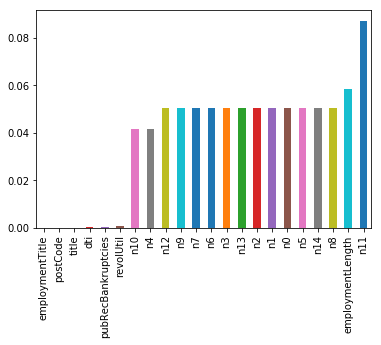

In [10]:
# nan可视化
missing = data_train.isnull().sum()/len(data_train) 
missing = missing[missing > 0] 
missing.sort_values(inplace=True) 
missing.plot.bar()

了解哪些列存在 “nan”, 并可以把nan的个数打印，主要的目的在于 nan存在的个数是否真的很大，如果很小一般选 择填充，如果使用lgb等树模型可以直接空缺，让树自己去优化，但如果nan存在的过多、可以考虑删掉

### 查看训练集测试集中特征属性只有一值的特征

In [11]:
one_value_feature = [col for col in data_train.columns if data_train[col].nunique() <= 1]

In [12]:
one_value_feature

['policyCode']

### 总结:
47列数据中有22列都缺少数据，这在现实世界中很正常。‘policyCode’具有一个唯一值(或全部缺失)。有很多连续变量和一些分类变量。

### 查看特征有哪些类型
1. 特征一般都是由类别型特征和数值型特征组成 
2. 类别型特征有时具有非数值关系，有时也具有数值关系。比如‘grade’中的等级A，B，C等，是否只是单纯的分类，还是A优于其他要结合业务判断。 
3. 数值型特征本是可以直接在模型中使用的，但是对一些线性模型来说，一般是会进行分箱。从模型效果上来看，特征分箱主要是为了降低变量的复杂性，减少变量噪音对模型的影响，提高自变量 和因变量的相关度。从而使模型更加稳定。

In [13]:
numerical_fea = list(data_train.select_dtypes(exclude=['object']).columns) 
category_fea = list(filter(lambda x: x not in numerical_fea,list(data_train.columns)))

In [14]:
numerical_fea

['id',
 'loanAmnt',
 'term',
 'interestRate',
 'installment',
 'employmentTitle',
 'homeOwnership',
 'annualIncome',
 'verificationStatus',
 'isDefault',
 'purpose',
 'postCode',
 'regionCode',
 'dti',
 'delinquency_2years',
 'ficoRangeLow',
 'ficoRangeHigh',
 'openAcc',
 'pubRec',
 'pubRecBankruptcies',
 'revolBal',
 'revolUtil',
 'totalAcc',
 'initialListStatus',
 'applicationType',
 'title',
 'policyCode',
 'n0',
 'n1',
 'n2',
 'n3',
 'n4',
 'n5',
 'n6',
 'n7',
 'n8',
 'n9',
 'n10',
 'n11',
 'n12',
 'n13',
 'n14']

In [15]:
category_fea

['grade', 'subGrade', 'employmentLength', 'issueDate', 'earliesCreditLine']

### 数值变量分析
数值型变量包括连续型变量与离散型变量

划分数值型变量中的连续变量和分类变量

In [16]:
#过滤数值型类别特征
def get_numerical_serial_fea(data,feas):
    numerical_serial_fea = [] 
    numerical_noserial_fea = [] 
    for fea in feas:
        temp = data[fea].nunique() 
        if temp <= 10:
            numerical_noserial_fea.append(fea)
            continue
        numerical_serial_fea.append(fea)
    return numerical_serial_fea,numerical_noserial_fea
numerical_serial_fea,numerical_noserial_fea = get_numerical_serial_fea(data_train,numerical_fea)

In [17]:
numerical_serial_fea

['id',
 'loanAmnt',
 'interestRate',
 'installment',
 'employmentTitle',
 'annualIncome',
 'purpose',
 'postCode',
 'regionCode',
 'dti',
 'delinquency_2years',
 'ficoRangeLow',
 'ficoRangeHigh',
 'openAcc',
 'pubRec',
 'pubRecBankruptcies',
 'revolBal',
 'revolUtil',
 'totalAcc',
 'title',
 'n0',
 'n1',
 'n2',
 'n3',
 'n4',
 'n5',
 'n6',
 'n7',
 'n8',
 'n9',
 'n10',
 'n13',
 'n14']

In [18]:
numerical_noserial_fea

['term',
 'homeOwnership',
 'verificationStatus',
 'isDefault',
 'initialListStatus',
 'applicationType',
 'policyCode',
 'n11',
 'n12']

数值类别型变量分析

In [19]:
data_train['term'].value_counts()#离散型变量

3    606902
5    193098
Name: term, dtype: int64

In [20]:
data_train['homeOwnership'].value_counts()#离散型变量

0    395732
1    317660
2     86309
3       185
5        81
4        33
Name: homeOwnership, dtype: int64

In [21]:
data_train['verificationStatus'].value_counts()#离散型变量

1    309810
2    248968
0    241222
Name: verificationStatus, dtype: int64

In [22]:
data_train['initialListStatus'].value_counts()#离散型变量

0    466438
1    333562
Name: initialListStatus, dtype: int64

In [23]:
data_train['applicationType'].value_counts()#离散型变量

0    784586
1     15414
Name: applicationType, dtype: int64

In [24]:
data_train['policyCode'].value_counts()#离散型变量，无用，全部一个值

1.0    800000
Name: policyCode, dtype: int64

In [25]:
data_train['n11'].value_counts()#离散型变量，相差悬殊，用不用再分析

0.0    729682
1.0       540
2.0        24
4.0         1
3.0         1
Name: n11, dtype: int64

In [26]:
data_train['n12'].value_counts()#离散型变量，相差悬殊，用不用再分析

0.0    757315
1.0      2281
2.0       115
3.0        16
4.0         3
Name: n12, dtype: int64

数值连续型变量分析

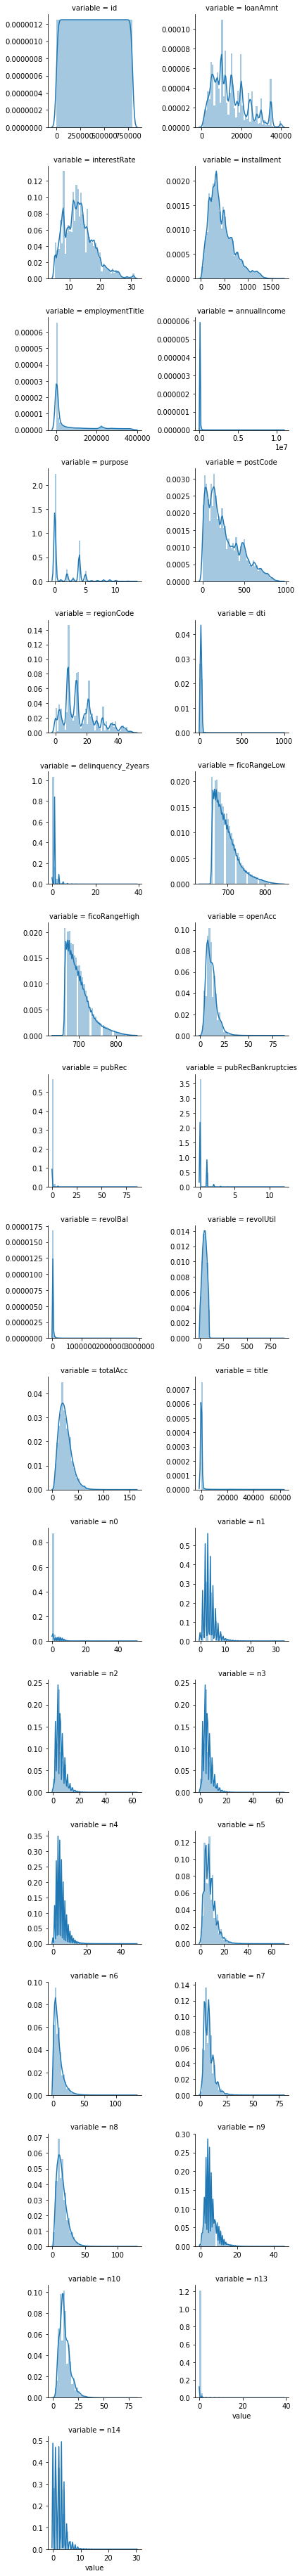

In [27]:
#每个数字特征得分布可视化
f = pd.melt(data_train, value_vars=numerical_serial_fea)
g = sns.FacetGrid(f, col="variable", col_wrap=2, sharex=False, sharey=False) 
g = g.map(sns.distplot, "value")

查看某一个数值型变量的分布，查看变量是否符合正态分布，如果不符合正太分布的变量可以log化后再观察 下是否符合正态分布。
如果想统一处理一批数据变标准化 必须把这些之前已经正态化的数据提出

Text(0, 0.5, 'Probability')

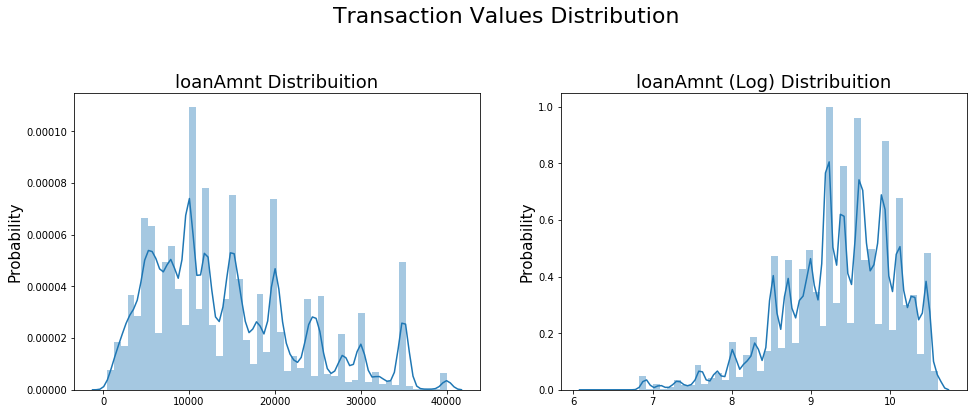

In [29]:
#Ploting Transaction Amount Values Distribution
plt.figure(figsize=(16,12))
plt.suptitle('Transaction Values Distribution', fontsize=22) 
plt.subplot(221)
sub_plot_1 = sns.distplot(data_train['loanAmnt']) 
sub_plot_1.set_title("loanAmnt Distribuition", fontsize=18) 
sub_plot_1.set_xlabel("") 
sub_plot_1.set_ylabel("Probability", fontsize=15)
plt.subplot(222)
sub_plot_2 = sns.distplot(np.log(data_train['loanAmnt'])) 
sub_plot_2.set_title("loanAmnt (Log) Distribuition", fontsize=18) 
sub_plot_2.set_xlabel("")
sub_plot_2.set_ylabel("Probability", fontsize=15)

非数值类别型变量分析

In [30]:
category_fea

['grade', 'subGrade', 'employmentLength', 'issueDate', 'earliesCreditLine']

In [31]:
data_train['grade'].value_counts()

B    233690
C    227118
A    139661
D    119453
E     55661
F     19053
G      5364
Name: grade, dtype: int64

In [32]:
data_train['subGrade'].value_counts()

C1    50763
B4    49516
B5    48965
B3    48600
C2    47068
C3    44751
C4    44272
B2    44227
B1    42382
C5    40264
A5    38045
A4    30928
D1    30538
D2    26528
A1    25909
D3    23410
A3    22655
A2    22124
D4    21139
D5    17838
E1    14064
E2    12746
E3    10925
E4     9273
E5     8653
F1     5925
F2     4340
F3     3577
F4     2859
F5     2352
G1     1759
G2     1231
G3      978
G4      751
G5      645
Name: subGrade, dtype: int64

In [33]:
data_train['employmentLength'].value_counts()

10+ years    262753
2 years       72358
< 1 year      64237
3 years       64152
1 year        52489
5 years       50102
4 years       47985
6 years       37254
8 years       36192
7 years       35407
9 years       30272
Name: employmentLength, dtype: int64

In [34]:
data_train['issueDate'].value_counts()

2016-03-01    29066
2015-10-01    25525
2015-07-01    24496
2015-12-01    23245
2014-10-01    21461
2016-02-01    20571
2015-11-01    19453
2015-01-01    19254
2015-04-01    18929
2015-08-01    18750
2015-05-01    17119
2016-01-01    16792
2014-07-01    16355
2015-06-01    15236
2015-09-01    14950
2016-04-01    14248
2014-11-01    13793
2015-03-01    13549
2016-08-01    13301
2015-02-01    12881
2016-07-01    12835
2016-06-01    12270
2016-12-01    11562
2016-10-01    11245
2016-11-01    11172
2014-05-01    10886
2014-04-01    10830
2016-05-01    10680
2014-08-01    10648
2016-09-01    10165
              ...  
2010-01-01      355
2009-10-01      305
2009-09-01      270
2009-08-01      231
2009-07-01      223
2009-06-01      191
2009-05-01      190
2009-04-01      166
2009-03-01      162
2009-02-01      160
2009-01-01      145
2008-12-01      134
2008-03-01      130
2008-11-01      113
2008-02-01      105
2008-04-01       92
2008-01-01       91
2008-10-01       62
2007-12-01       55


In [35]:
data_train['earliesCreditLine'].value_counts()

Aug-2001    5567
Aug-2002    5403
Sep-2003    5403
Oct-2001    5258
Aug-2000    5246
Sep-2004    5219
Sep-2002    5170
Aug-2003    5116
Oct-2000    5034
Oct-2002    5034
Oct-2003    4969
Aug-2004    4904
Nov-2000    4798
Sep-2001    4787
Sep-2000    4780
Nov-1999    4773
Oct-1999    4678
Oct-2004    4647
Sep-2005    4608
Jul-2003    4586
Nov-2001    4514
Aug-2005    4494
Jul-2001    4480
Aug-1999    4446
Sep-1999    4441
Dec-2001    4379
Jul-2002    4342
Aug-2006    4283
Mar-2001    4268
May-2001    4223
            ... 
Feb-1962       2
Aug-1950       2
Sep-1961       2
Jul-1961       2
Sep-1959       2
Nov-1962       2
Apr-1955       2
Jul-1955       1
Nov-1954       1
Aug-1958       1
Feb-1960       1
Jan-1946       1
May-1960       1
Mar-1958       1
Jun-1958       1
Mar-1957       1
Sep-1953       1
Oct-1957       1
Sep-1957       1
Dec-1951       1
Nov-1953       1
May-1957       1
Mar-1962       1
Jan-1944       1
Aug-1946       1
Aug-1955       1
Apr-1958       1
Oct-2015      

In [36]:
data_train['isDefault'].value_counts()

0    640390
1    159610
Name: isDefault, dtype: int64

### 总结:
1. 上面我们用value_counts()等函数看了特征属性的分布，但是图表是概括原始信息最便捷的方式。
2. 数无形时少直觉。
3. 同一份数据集，在不同的尺度刻画上显示出来的图形反映的规律是不一样的。python将数据转化成图表，但结
论是否正确需要由你保证。

### 变量分布可视化
单一变量分布可视化

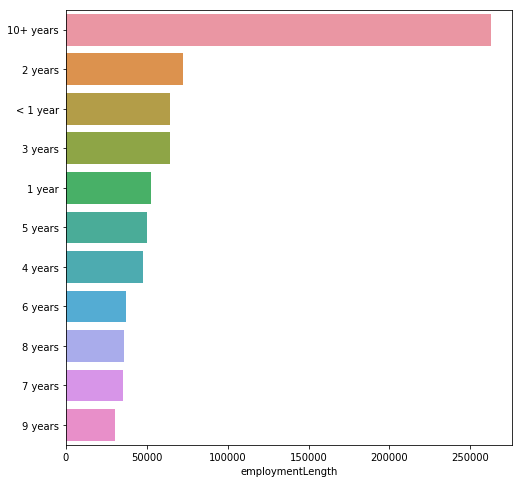

In [38]:
plt.figure(figsize=(8, 8)) 
sns.barplot(data_train["employmentLength"].value_counts(dropna=False)[:20], data_train["employmentLength"].value_counts(dropna=False).keys()[:20])
plt.show()

根据y值可视化x的分布

In [39]:
train_loan_fr = data_train.loc[data_train['isDefault'] == 1]
train_loan_nofr = data_train.loc[data_train['isDefault'] == 0]

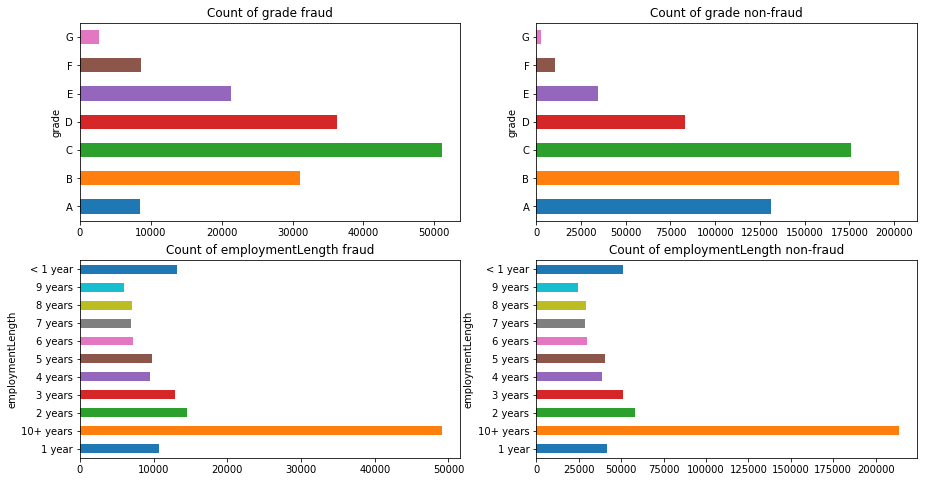

In [40]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 8)) 
train_loan_fr.groupby('grade')['grade'].count().plot(kind='barh', ax=ax1, title='Count of grade fraud')
train_loan_nofr.groupby('grade')['grade'].count().plot(kind='barh', ax=ax2, title='Count of grade non-fraud') 
train_loan_fr.groupby('employmentLength')['employmentLength'].count().plot(kind='barh', ax=ax3, title='Count of employmentLength fraud') 
train_loan_nofr.groupby('employmentLength')['employmentLength'].count().plot(kind='barh', ax=ax4, title='Count of employmentLength non-fraud')
plt.show()

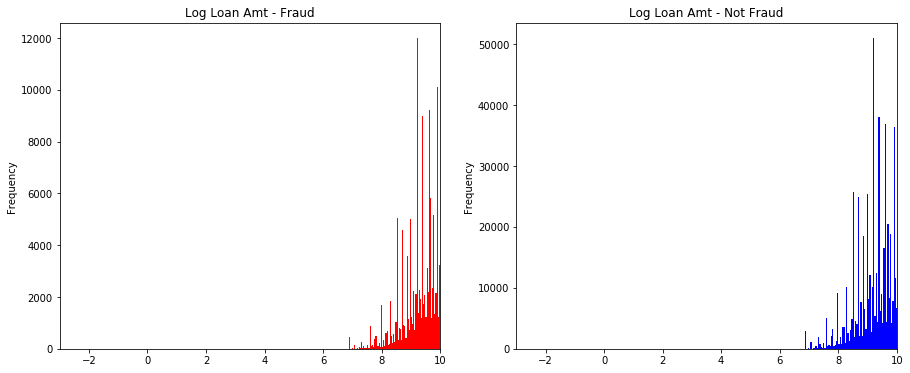

In [47]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 6)) 
data_train.loc[data_train['isDefault'] == 1]['loanAmnt'].apply(np.log).plot(kind='hist', bins=100,title='Log Loan Amt - Fraud', color='r',xlim=(-3, 10),ax= ax1) 
data_train.loc[data_train['isDefault'] == 0]['loanAmnt'].apply(np.log).plot(kind='hist', bins=100,title='Log Loan Amt - Not Fraud', color='b',xlim=(-3, 10),ax=ax2)

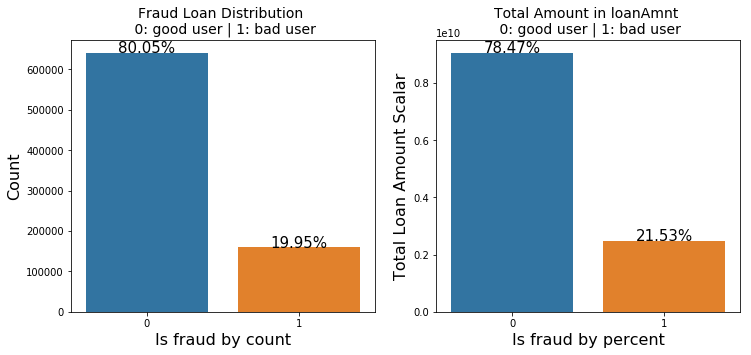

In [50]:
total = len(data_train)
total_amt = data_train.groupby(['isDefault'])['loanAmnt'].sum().sum() 
plt.figure(figsize=(12,5)) 
plt.subplot(121)##1代表行，2代表列，所以一共有2个图，1代表此时绘制第一个图。
plot_tr = sns.countplot(x='isDefault',data=data_train)#data_train‘isDefault’这个特征每种类别 的数量**
plot_tr.set_title("Fraud Loan Distribution \n 0: good user | 1: bad user", fontsize=14) 
plot_tr.set_xlabel("Is fraud by count", fontsize=16)
plot_tr.set_ylabel('Count', fontsize=16)
for p in plot_tr.patches:
    height = p.get_height()
    plot_tr.text(p.get_x()+p.get_width()/2.,
    height + 3, '{:1.2f}%'.format(height/total*100), ha="center", fontsize=15)

percent_amt = (data_train.groupby(['isDefault'])['loanAmnt'].sum())
percent_amt = percent_amt.reset_index()
plt.subplot(122)
plot_tr_2 = sns.barplot(x='isDefault', y='loanAmnt', dodge=True, data=percent_amt) 
plot_tr_2.set_title("Total Amount in loanAmnt \n 0: good user | 1: bad user", fontsize=14) 
plot_tr_2.set_xlabel("Is fraud by percent", fontsize=16)
plot_tr_2.set_ylabel('Total Loan Amount Scalar', fontsize=16) 
for p in plot_tr_2.patches:
    height = p.get_height()
    plot_tr_2.text(p.get_x()+p.get_width()/2.,
    height + 3, '{:1.2f}%'.format(height/total_amt * 100), ha="center", fontsize=15)

时间格式处理与查看

In [51]:
#转化成时间格式
data_train['issueDate'] = pd.to_datetime(data_train['issueDate'],format='%Y-%m-%d') 
startdate = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d') 
data_train['issueDateDT'] = data_train['issueDate'].apply(lambda x: x-startdate).dt.days

In [52]:
#转化成时间格式
data_test_a['issueDate'] = pd.to_datetime(data_train['issueDate'],format='%Y-%m-%d') 
startdate = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d') 
data_test_a['issueDateDT'] = data_test_a['issueDate'].apply(lambda x: x-startdate).dt.days

Text(0.5, 1.0, 'Distribution of issueDateDT dates')

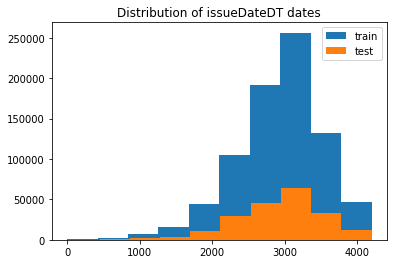

In [53]:
plt.hist(data_train['issueDateDT'], label='train')
plt.hist(data_test_a['issueDateDT'], label='test')
plt.legend()
plt.title('Distribution of issueDateDT dates')
#train 和 test issueDateDT 日期有重叠 所以使用基于时间的分割进行验证是不明智的

透视图

In [54]:
#透视图 索引可以有多个，“columns(列)”是可选的，聚合函数aggfunc最后是被应用到了变量“values”中你所 列举的项目上。
pivot = pd.pivot_table(data_train, index=['grade'], columns=['issueDateDT'], values= ['loanAmnt'], aggfunc=np.sum)

In [55]:
pivot

loanAmnt                                                         \
issueDateDT     0        30       61       92       122      153       183    
grade                                                                         
A                NaN  53650.0  42000.0  19500.0  34425.0  63950.0   43500.0   
B                NaN  13000.0  24000.0  32125.0   7025.0  95750.0  164300.0   
C                NaN  68750.0   8175.0  10000.0  61800.0  52550.0  175375.0   
D                NaN      NaN   5500.0   2850.0  28625.0      NaN  167975.0   
E             7500.0      NaN  10000.0      NaN  17975.0   1500.0   94375.0   
F                NaN      NaN  31250.0   2125.0      NaN      NaN       NaN   
G                NaN      NaN      NaN      NaN      NaN      NaN       NaN   

                                             ...                              \
issueDateDT      214       245       274     ...            3926        3957   
grade                                        ...                               
A            168825.0   85600.0  101825.0    ...      13093850.0  11757325.0   
B            303175.0  434425.0  538450.0    ...      16863100.0  17275175.0   
C            151100.0  243725.0  393150.0    ...      17502375.0  17471500.0   
D            171325.0  192900.0  269325.0    ...      11403075.0  10964150.0   
E            116450.0   42000.0  139775.0    ...       3983050.0   3410125.0   
F             49000.0   27000.0   43000.0    ...       1074175.0    868925.0   
G             24625.0       NaN       NaN    ...         56100.0    243275.0   

                                                                       \
issueDateDT        3987        4018        4048       4079       4110   
grade                                                                   
A            11945975.0   9144000.0   7977650.0  6888900.0  5109800.0   
B            16217500.0  11431350.0   8967750.0  7572725.0  4884600.0   
C            16111225.0  11973675.0  10184450.0  7765000.0  5354450.0   
D            10747675.0   7082050.0   7189625.0  5195700.0  3455175.0   
E             3107150.0   2341825.0   2225675.0  1643675.0  1091025.0   
F              761675.0    685325.0    665750.0   685200.0   316700.0   
G              224825.0     64050.0    198575.0   245825.0    53125.0   

                                              
issueDateDT       4140       4171       4201  
grade                                         
A            3919275.0  2694025.0  2245625.0  
B            4329400.0  3922575.0  3257100.0  
C            4552600.0  2870050.0  2246250.0  
D            3038500.0  2452375.0  1771750.0  
E            1131625.0   883950.0   802425.0  
F             315075.0    72300.0        NaN  
G              23750.0    25100.0     1000.0  

[7 rows x 139 columns]

### 总结
数据探索性分析是我们初步了解数据，熟悉数据为特征工程做准备的阶段，甚至很多时候EDA阶段提取出来的特 征可以直接当作规则来用。可见EDA的重要性，这个阶段的主要工作还是借助于各个简单的统计量来对数据整体 的了解，分析各个类型变量相互之间的关系，以及用合适的图形可视化出来直观观察。